In [9]:
import os
import sys
import re
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import pickle
import multiprocessing as mp

In [10]:
# jupyter notebook settings for debugging
%load_ext autoreload
%autoreload 2

In [11]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_vasp
from statmechlib.preprocessing import Trajectory, select_nodes, scale_configuration, pair_dist
from statmechlib.preprocessing import force_targ, get_stats_EAM_per_atom, get_stats_EAM_per_box

In [66]:
# Define locations of relevant datasets

target_raw = '../data/target_raw'
target_proc = '../data/target_processed'
working = '../data/working'
reports = '../reports/'

# MD trajectories
datasets_MD = ['bcc_npt_langevin_300K',
            'fcc_npt_langevin_300K',
            'vac_npt_langevin_2000K',
            'i110_npt_langevin_2000K',
            'i111_npt_langevin_2000K',
            'screw_111_npt_langevin_2000K',
            'bcc_npt_langevin_3700K',
            'liq_3700K',
            'liq_5000K']

# 0K relaxed structures
datasets_0k = ['bcc_0k',
               'fcc_0k',
               'vac_0k',
               'i110_0k',
               'i111_0k',
               'screw_111_0k']

# equations of state for BCC and FCC lattices
configs = ['v0.8','v0.9','v1.0','v1.1','v1.2','v1.3','v1.4','v1.5']

datasets_eos_bcc = ['eq_st_bcc/' + s for s in configs]
datasets_eos_fcc = ['eq_st_fcc/' + s for s in configs]

# bain path
configs = ['1.00', '1.05', '1.10', '1.15', '1.20', '1.25', '1.30', '1.35', '1.40', '1.45', '1.50', '1.55']

datasets_bain = ['bain_path/' + s for s in configs]

# vacancy interactions

configs = ['v2_r1', 'v2_r2', 'v2_r3', 'v3_1_555', 'v3_3_555', 'v4_2_555', 'v4_5_555', 'v5_555', 'v6_555', 'v6_6x6x6_360']#, 'prf_360']

datasets_vacint = ['vacint/' + s for s in configs]

# defined dataset directories relative to the current directory (/notebooks)
trajdirs_MD = [target_raw + '/' + dataset for dataset in datasets_MD]
trajdirs_0k = [target_raw + '/' + dataset for dataset in datasets_0k]
trajdirs_eos_bcc = [target_raw + '/' + dataset for dataset in datasets_eos_bcc]
trajdirs_eos_fcc = [target_raw + '/' + dataset for dataset in datasets_eos_fcc]
trajdirs_bain = [target_raw + '/' + dataset for dataset in datasets_bain]
trajdirs_vacint = [target_raw + '/' + dataset for dataset in datasets_vacint]

In [13]:
%%time

# set up a multiprocessing pool
pool = mp.Pool()

# read vacancy interactins in parallel
output_data = pool.map(read_vasp, trajdirs_vacint)
trajectories_vacint = dict(zip(datasets_vacint, output_data))
print('Done with vacint')

# read MD trajectories in parallel
output_data = pool.map(read_vasp, trajdirs_MD)
trajectories_MD = dict(zip(datasets_MD, output_data))
print('Done with MD')

# read 0K configurations in parallel
output_data = pool.map(read_vasp, trajdirs_0k)
trajectories_0k = dict(zip(datasets_0k, output_data))
print('Done with 0k')

# read BCC EOS in parallel
output_data = pool.map(read_vasp, trajdirs_eos_bcc)
trajectories_eos_bcc = dict(zip(datasets_eos_bcc, output_data))
print('Done with BCC EOS')

# read BCC EOS in parallel
output_data = pool.map(read_vasp, trajdirs_eos_fcc)
trajectories_eos_fcc = dict(zip(datasets_eos_fcc, output_data))
print('Done with FCC EOS')

# read bain path in parallel
output_data = pool.map(read_vasp, trajdirs_bain)
trajectories_bain = dict(zip(datasets_bain, output_data))
print('Done with bain path')

pool.close()
pool.join()

Done with vacint
Done with MD
Done with 0k
Done with BCC EOS
Done with FCC EOS
Done with bain path
CPU times: user 465 ms, sys: 197 ms, total: 662 ms
Wall time: 5min 22s


In [77]:
# Convert MD trajectory dicts to objects
trjs_MD = {}
for k, trj in trajectories_MD.items():
    trjs_MD[k] = Trajectory(trj, inplace=False)
    
# Convert 0K configs to objects
trjs_0k = {}
for k, trj in trajectories_0k.items():
    trjs_0k[k] = Trajectory(trj, inplace=False)[-1]

# Convert bcc eos configs to objects
trjs_eos_bcc = {}
for k, trj in trajectories_eos_bcc.items():
    trjs_eos_bcc[k] = Trajectory(trj, inplace=False)[-1]
    
# Convert fcc eos configs to objects
trjs_eos_fcc = {}
for k, trj in trajectories_eos_fcc.items():
    trjs_eos_fcc[k] = Trajectory(trj, inplace=False)[-1]
    
# Convert bain path configs to objects
trjs_bain = {}
for k, trj in trajectories_bain.items():
    trjs_bain[k] = Trajectory(trj, inplace=False)[-1]
    
# Convert vacint configs to objects
trjs_vacint = {}
for k, trj in trajectories_vacint.items():
    trjs_vacint[k] = Trajectory(trj, inplace=False)[-1]

In [78]:
print(trjs_0k['bcc_0k']['energy'])
trjs_0k['bcc_0k']['energy'] = [-1656.28114021]

[-1656.32569971]


In [79]:
# plt.figure(figsize=(20,10))
# ratio = [trjs_bain[key]['box'][0][2,2]/trjs_bain[key]['box'][0][0,0] for key in datasets_bain]
# plt.plot(ratio, np.array([trjs_bain[key]['energy'] for key in datasets_bain])/128.- trjs_bain['bain_path/1.00']['energy'][-1]/128.)
# plt.xlim(1.0, 1.95)
# plt.grid(True)

In [80]:
# plt.figure(figsize=(20,10))
# #ratio = [trjs_vacint[key]['box'][0][2,2]/trjs_bain[key]['box'][0][0,0] for key in datasets_bain]
# plt.title('Vacancy cluster formation energies')
# nat = np.array([len(trjs_vacint[key]['xyz'][-1]) for key in sorted(datasets_vacint)])
# enes_big =   [trjs_vacint[key]['energy'][-1] + 5598.713470/432*nat[i] for i, key in enumerate(sorted(datasets_vacint))]
# enes_small = [trjs_vacint[key]['energy'][-1] + 3239.858169/250*nat[i] for i, key in enumerate(sorted(datasets_vacint))]

# #plt.plot(np.array([trjs_vacint[key]['energy'][-1] for key in datasets_vacint])/nat - 8.9)
# #plt.xlim(1.0, 1.95)
# plt.grid(True)
# plt.plot(enes_big)
# plt.plot(enes_small)
# #plt.plot(np.array([trjs_vacint[key]['energy'][-1] for key in sorted(datasets_vacint)]) - trjs_0k['bcc_0k']['energy'][-1]/128.*nat)
# x_ticks = (list(range(len(trjs_vacint.keys()))), sorted(list(trjs_vacint.keys())))
# plt.xticks(*x_ticks)


# print([trjs_vacint[key]['energy'][-1] + 5598.713470/432*nat[i] for i, key in enumerate(sorted(datasets_vacint))])
# print([trjs_vacint[key]['energy'][-1] + 3239.858169/250*nat[i] for i, key in enumerate(sorted(datasets_vacint))])
# print(nat)

In [81]:
# Join relaxed configurations into pseudo-trajectories

# join 0 K configurations into a pseudo-trajectory
traj_0k = copy.deepcopy(trjs_0k['bcc_0k'])
for k, trj in sorted(trjs_0k.items()):
    if 'bcc_0k' not in k:
        traj_0k.append(trj)

# join eos bcc configurations into a pseudo-trajectory
traj_eos_bcc = copy.deepcopy(trjs_eos_bcc['eq_st_bcc/v0.8'])
for k, trj in sorted(trjs_eos_bcc.items()):
    if k != 'eq_st_bcc/v0.8':
        traj_eos_bcc.append(trj)

# join eos fcc configurations into a pseudo-trajectory
traj_eos_fcc = copy.deepcopy(trjs_eos_fcc['eq_st_fcc/v0.8'])
for k, trj in sorted(trjs_eos_fcc.items()):
    if k != 'eq_st_fcc/v0.8':
    #if ('v0.8' in k) or ('v0.9' in k) or ('v1.1' in k) or ('v1.2' in k):
        traj_eos_fcc.append(trj)
        
# join bain path configurations into a pseudo-trajectory
traj_bain = copy.deepcopy(trjs_bain['bain_path/1.00'])
for k, trj in sorted(trjs_bain.items()):
    if k != 'bain_path/1.00':
        traj_bain.append(trj)
        
# join vacint configurations into a pseudo-trajectory
traj_vacint = copy.deepcopy(trjs_vacint['vacint/v2_r1'])
for k, trj in sorted(trjs_vacint.items()):
    if k != 'vacint/v2_r1':
        traj_vacint.append(trj)

In [82]:
# Create a dictionary of trajectories
trjs = {}
trjs.update(trjs_MD)
trjs['relax'] = traj_0k
trjs['eos_bcc'] = traj_eos_bcc
trjs['eos_fcc'] = traj_eos_fcc
trjs['bain'] = traj_bain
trjs['vacint'] = traj_vacint

In [83]:
# shift zero of energy to by subtracting intra-atomic contributions (energy of an isolated atom)
u_total = traj_0k['energy'][0]/len(traj_0k['xyz'][0]) # total energy of a BCC lattice from DFT
u_lattice = -8.9 # experimental lattice energy of a BCC lattice
#u_lattice = -8.89965188
u_intra = u_total - u_lattice # internal energy per atom (to be subtracted from all atoms)

for key, trj_i in trjs.items():
    #print(key, type(trj_i))
    trj_i.set_zero_energy(u_intra, inplace=True)

In [84]:
u_total, u_lattice, u_intra, trjs['relax']['energy'], trjs['vacint']['energy']

(-12.939696407890626,
 -8.9,
 -4.0396964078906255,
 [-1139.2,
  -907.0154879478124,
  -1136.4010143821092,
  -1136.7508187321096,
  -1190.2611772847656,
  -1127.1746971578905],
 [-3829.2940277670314,
  -3828.939307777031,
  -3829.447190347031,
  -2193.3418208310154,
  -2193.5559807510153,
  -2180.5329819289063,
  -2182.0693779089065,
  -2169.556598046797,
  -2159.4839017546874,
  -3783.0891523685937])

In [85]:
np.array(trjs['relax']['energy'])/np.array([len(x) for x in trjs['relax']['xyz']])

array([-8.9       , -8.39829156, -8.80931019, -8.81202185, -8.81674946,
       -8.87539132])

In [86]:
trjs_0k['bcc_0k']['total_energy'], trjs['relax'][0]['energy']

([-1656.3257], [-1139.2])

In [87]:
# Create configurations and energies based on universal equation of state for BCC tungsten
traj_eos = scale_configuration(copy.deepcopy(trjs['relax'][0]), 0.5)
for scale in list(np.linspace(0.55, 1.5, 20)):
    traj_scale = copy.deepcopy(trjs['relax'][0])
    traj_eos.append(scale_configuration(traj_scale, scale))

trjs['eos'] = traj_eos

In [88]:
# Create an artificial 'infinite' configuration with large box and 0 energy
#traj_inf = copy.deepcopy(trjs_0k['bcc_0k'])
traj_inf = copy.deepcopy(trjs['relax'][0])
traj_inf = scale_configuration(traj_inf, 100.0)
trjs['inf'] = traj_inf

In [89]:
# Set temperature to 300 K (for convenience)
pseudo_trajs = ['relax', 'bain', 'vacint', 'eos_bcc', 'eos', 'eos_fcc', 'inf']

for key in pseudo_trajs:
    trjs[key]['temp'] = [300.0 for _ in range(len(trjs[key]['energy']))]

[63535.799511577519, 38120.280479022789, 22211.18670800457, 12386.59528057528, 6422.140945798812, 2881.74142408127, 845.26563726277175, -271.80472210709036, -837.17110899865236, -1079.5267350307165, -1139.2, -1100.8887858645915, -1014.6561261471662, -909.28071611311475, -800.66334446353414, -697.06112023288756, -602.3043063713144, -517.74299945651205, -443.40328537746308, -378.65794151906402, -322.60372455595439]
[-1022.85130544, -1114.86293192, -1139.1999955899998, -1123.98066039, -1084.68268356, -1031.68537524, -971.36389295, -907.7312258099998]
[-816.7254944178125, -890.3914020378126, -910.3360622078125, -897.9182829678124, -865.9315437078125, -822.6787388678125, -773.4453470678123, -721.4784398478124]


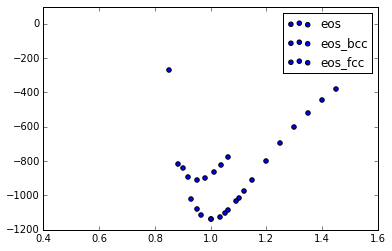

In [90]:
for key, trj in trjs.items():
    #print(i, list(zip(trj['atom_name'], trj['atom_num'])), len(trj['temp']))
    if 'eos' in key:
        plt.scatter([np.linalg.det(b)**(1./3.)/12.744894 for b in trj['box']][:-1], trj['energy'][:-1], label=key)
        print(trj['energy'][:])
plt.legend()
#plt.xlim(-1780,-1100)
plt.ylim(-1200,100)
plt.show()

[7.9142763063139432, 9.2354878027839309, 8.0295707174242281, 8.0295707174242281, 7.4751982339096186, 7.943014712295847]


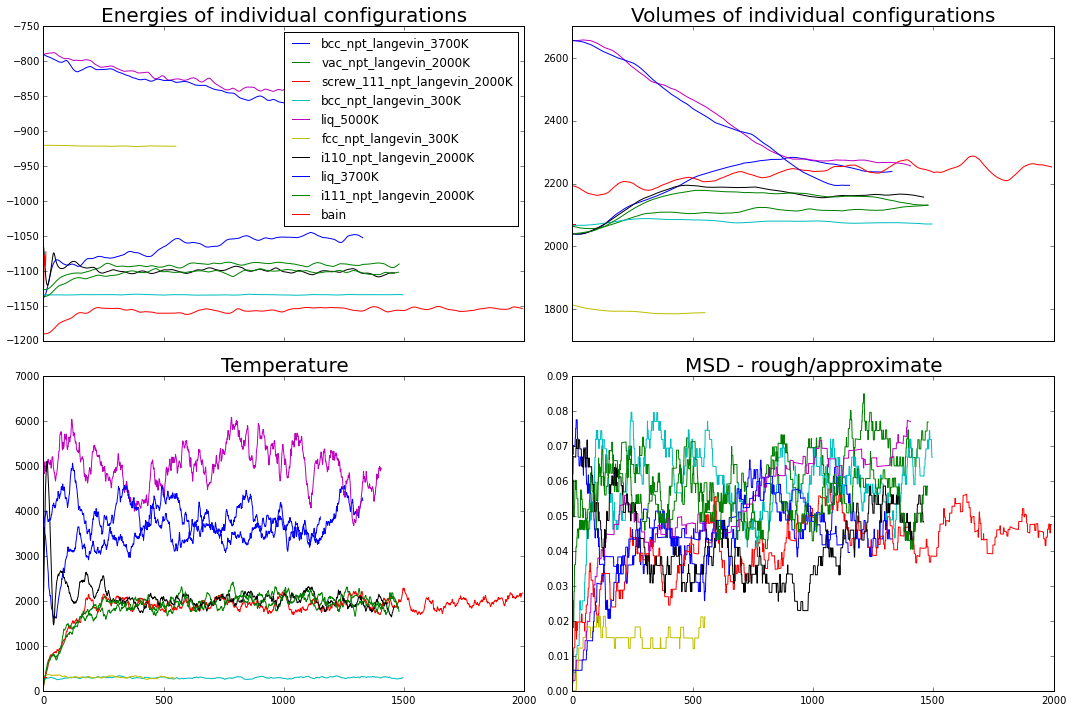

In [91]:
def get_msd(xyzs):
    """Return mean squared displacement (msd) for a given trajectory (traj)."""
    msd = []
    for rs in xyzs:
        msd.append(np.mean((rs - xyzs[0])**2))
    #msd = [0.0 for _ in range(len(xyzs))]
    return np.array(msd)

fig, axes = plt.subplots(2, 2, sharex='col', figsize=(15,10))

for key, traj in trjs.items():
        
    if 'relax' in key or 'eos' in key or 'vacint' in key or 'inf' in key:
        continue

    #axes[0,0].plot([e/x.shape[0] for e, x in zip(traj['energy'], traj['xyz'])], label=dset)
    if 'screw' in key:
        axes[0,0].plot([e for e, x in zip(traj['energy'], traj['xyz'])], label=key)
        axes[0,1].plot([np.linalg.det(b) for b in traj['box']], label=key)
    else:
        axes[0,0].plot([e for e, x in zip(traj['energy'], traj['xyz'])], label=key)
        axes[0,1].plot([np.linalg.det(b) for b in traj['box']], label=key)


    axes[1,0].plot([t for t in traj['temp']], label=key)

    msd = get_msd(traj['xyz'])
    axes[1,1].plot(msd, label=key)

axes[0,0].legend()
axes[0,0].set_title('Energies of individual configurations', fontsize=20)
axes[0,1].set_title('Volumes of individual configurations', fontsize=20)       
axes[1,0].set_title('Temperature', fontsize=20)
axes[1,1].set_title('MSD - rough/approximate', fontsize=20)
fig.tight_layout()

print([128*128/np.linalg.det(b) for b in trjs['relax']['box']])

In [92]:
[(k, len(v['energy'])) for k, v in trjs.items()]

[('bcc_npt_langevin_3700K', 1329),
 ('eos', 21),
 ('vac_npt_langevin_2000K', 1480),
 ('inf', 1),
 ('relax', 6),
 ('screw_111_npt_langevin_2000K', 1992),
 ('bcc_npt_langevin_300K', 1496),
 ('eos_bcc', 8),
 ('liq_5000K', 1406),
 ('fcc_npt_langevin_300K', 552),
 ('vacint', 10),
 ('eos_fcc', 8),
 ('i110_npt_langevin_2000K', 1461),
 ('liq_3700K', 1153),
 ('i111_npt_langevin_2000K', 1477),
 ('bain', 12)]

In [93]:
slices = {'bcc_npt_langevin_300K':slice(500, None,5),
        'fcc_npt_langevin_300K':slice(50, None, 4),
        'vac_npt_langevin_2000K':slice(300, None, 5),
        'i110_npt_langevin_2000K':slice(800, None, 5),
        'i111_npt_langevin_2000K':slice(800, None, 5),
        'screw_111_npt_langevin_2000K':slice(1000, None, 5),
        'bcc_npt_langevin_3700K':slice(600, None, 5),
        'liq_3700K':slice(700, None, 5),
        'liq_5000K':slice(800, None, 5),
        'relax':slice(0, None, None),
        'eos_bcc':slice(0, None, None),
        'eos_fcc':slice(0, None, None),
        'eos':slice(0, None, None),
        'bain':slice(0, None, None),
        'vacint':slice(0, None, None),
        'inf':slice(0, None, None)
       }

In [94]:
trj_samples = {}
for key, traj in trjs.items():
    trj_samples[key] = traj[slices[key]]

In [95]:
[(k, len(v['energy'])) for k, v in trj_samples.items()]

[('bcc_npt_langevin_3700K', 146),
 ('liq_5000K', 122),
 ('vac_npt_langevin_2000K', 236),
 ('relax', 6),
 ('screw_111_npt_langevin_2000K', 199),
 ('i110_npt_langevin_2000K', 133),
 ('bcc_npt_langevin_300K', 200),
 ('i111_npt_langevin_2000K', 136),
 ('eos', 21),
 ('fcc_npt_langevin_300K', 126),
 ('vacint', 10),
 ('eos_fcc', 8),
 ('inf', 1),
 ('liq_3700K', 91),
 ('eos_bcc', 8),
 ('bain', 12)]

In [96]:
# # join all MD configurations into a pseudo-trajectory (to properly weigh phase stability)
# traj_md = copy.deepcopy(trj_samples['bcc_npt_langevin_300K'])

# for k, trj in sorted(trj_samples.items()):
#     print(k)
#     if 'vacint' in k or 'bain' in k or 'eos' in k or 'relax' in k or 'bcc_npt_langevin_300K' in k: 
#         continue
        
#     traj_md.append(trj)

#     print(len(traj_md['box']))

# # add inf configurations at the end to define zero of potential energy
# traj_inf_md = copy.deepcopy(traj_inf)
# traj_inf_md['ensemble'] = 'md'
# for i in range(200):
#     traj_md.append(traj_inf_md)

In [97]:
trj_samples['eos_bcc']['energy']

[-1022.85130544,
 -1114.86293192,
 -1139.1999955899998,
 -1123.98066039,
 -1084.68268356,
 -1031.68537524,
 -971.36389295,
 -907.7312258099998]

In [98]:
with open(os.path.join(working, "trj_all_samples.pickle"), 'wb') as fo:
    pickle.dump(trj_samples, fo, protocol=2)

In [105]:
9.5586708487499994/12.74489446*2.74

2.055000000806205

In [107]:
trj_samples['eos']['energy']

[63535.799511577519,
 38120.280479022789,
 22211.18670800457,
 12386.59528057528,
 6422.140945798812,
 2881.74142408127,
 845.26563726277175,
 -271.80472210709036,
 -837.17110899865236,
 -1079.5267350307165,
 -1139.2,
 -1100.8887858645915,
 -1014.6561261471662,
 -909.28071611311475,
 -800.66334446353414,
 -697.06112023288756,
 -602.3043063713144,
 -517.74299945651205,
 -443.40328537746308,
 -378.65794151906402,
 -322.60372455595439]

In [75]:
from statmechlib.preprocessing import find_min_distance
print('Minimum distance:', find_min_distance(trj_fit))

Appending to ../../statmechlib/statmechlib/preprocessing/utils.py
